# Description

Analyze research backtest results.

# Imports

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import datetime
import logging
import os

import pandas as pd

import core.config as cconfig
import core.plotting as coplotti
import dataflow.model as dtfmod
import dataflow_amp.system.Cx as dtfamsysc
import helpers.hdbg as hdbg
import helpers.henv as henv
import helpers.hgit as hgit
import helpers.hparquet as hparque
import helpers.hprint as hprint
import im_v2.common.data.client.historical_pq_clients as imvcdchpcl
import market_data as mdata
import oms.broker.ccxt.ccxt_utils as obccccut

/app/core/explore.py:39: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook as tauton
Don't recognize host: host_os_name=Linux, am_host_os_name=Linux


In [3]:
hdbg.init_logger(verbosity=logging.INFO)

_LOG = logging.getLogger(__name__)

_LOG.info("%s", henv.get_system_signature()[0])

hprint.config_notebook()

INFO: > cmd='/venv/lib/python3.9/site-packages/ipykernel_launcher.py -f /home/.local/share/jupyter/runtime/kernel-708089e0-0460-4deb-9eff-056a700eeffc.json'
INFO  # Git
  branch_name='CMTask8031_create_forecast_evaluator_kwargs_config'
  hash='3074ab50d'
  # Last commits:
    * 3074ab50d Juraj Smeriga Move import of an invoke target to a try catch (#8029)            (   4 hours ago) Wed Apr 24 08:36:50 2024  (HEAD -> CMTask8031_create_forecast_evaluator_kwargs_config, origin/master, origin/HEAD, origin/CMTask8031_create_forecast_evaluator_kwargs_config, master)
    * a0e6376d6 Sonaal   CmampTask7993_Make_the_Broker_more_robust_to_delays_ (#8024)      (  15 hours ago) Tue Apr 23 21:16:42 2024           
    * 2ae9dc982 Grigorii Pomazkin CmTask7894_document_release_process (#8007)                       (  16 hours ago) Tue Apr 23 20:34:25 2024           
# Machine info
  system=Linux
  node name=c0a82f9b1879
  release=5.15.0-1056-aws
  version=#61~20.04.1-Ubuntu SMP Wed Mar 13 17:40:41 U

# Build the config dict

In [4]:
# Get config from env when running the notebook via the `run_notebook.py` script.
default_config = cconfig.get_config_from_env()
if default_config:
    _LOG.info("Using config from env vars")
else:
    _LOG.info("Using hardwired config")
    # Build default config.
    amp_dir = hgit.get_amp_abs_path()
    dir_name = os.path.join(
        amp_dir,
        "/shared_data/backtest.danya/build_tile_configs.C11a.ccxt_v8_1-all.120T.2023-08-01_2024-01-31.ins.run0/tiled_results",
    )
    # Create a subfolder to store portfolio metrics.
    # The subfolder is marked by the datetime of the run, e.g.
    # "build_tile_configs.C11a.ccxt_v8_1-all.5T.2023-01-01_2024-03-20.ins.run0/portfolio_dfs/20240326_131724".
    # TODO(Danya): Factor out into a function.
    output_dir_name = os.path.join(
        dir_name.rstrip("tiled_results"),
        "portfolio_dfs",
        pd.Timestamp.utcnow().strftime("%Y%m%d_%H%M%S"),
    )
    default_config_dict = {
        "dir_name": dir_name,
        "output_dir_name": output_dir_name,
        "start_date": datetime.date(2023, 8, 1),
        "end_date": datetime.date(2024, 1, 31),
        "asset_id_col": "asset_id",
        "pnl_resampling_frequency": "D",
        "rule": "120T",
        "forecast_evaluator_class_name": "ForecastEvaluatorFromPrices",
        "im_client_config": {
            "vendor": "ccxt",
            "universe_version": "v8.1",
            "root_dir": "s3://cryptokaizen-data.preprod/v3",
            "partition_mode": "by_year_month",
            "dataset": "ohlcv",
            "contract_type": "futures",
            "data_snapshot": "",
            "aws_profile": "ck",
            "version": "v1_0_0",
            "download_universe_version": "v8",
            "tag": "downloaded_1min",
            "download_mode": "periodic_daily",
            "downloading_entity": "airflow",
            "resample_1min": False,
        },
        "annotate_forecasts_kwargs": {
            "style": "longitudinal",
            "quantization": 30,
            "liquidate_at_end_of_day": False,
            "initialize_beginning_of_day_trades_to_zero": False,
            "burn_in_bars": 3,
            "compute_extended_stats": True,
            "target_dollar_risk_per_name": 1.0,
            "modulate_using_prediction_magnitude": True,
            "prediction_abs_threshold": 0.0,
        },
        "forecast_evaluator_kwargs": {
            "price_col": "open",
            "volatility_col": "garman_klass_vol",
            "prediction_col": "feature",
        },
        "bin_annotated_portfolio_df_kwargs": {
            "proportion_of_data_per_bin": 0.2,
            "normalize_prediction_col_values": False,
        },
        "load_all_tiles_in_memory": True,
        "sweep_param": {
            "keys": (
                "forecast_evaluator_kwargs",
                "price_col",
            ),
            "values": [
                "open",
            ],
        },
    }
    # Add asset_id_to_share_decimals based on the `quantization` parameter:
    if not default_config_dict["annotate_forecasts_kwargs"]["quantization"]:
        asset_id_to_share_decimals = obccccut.get_asset_id_to_share_decimals(
            "amount_precision"
        )
        default_config_dict["annotate_forecasts_kwargs"][
            "asset_id_to_share_decimals"
        ] = asset_id_to_share_decimals
    else:
        default_config_dict["annotate_forecasts_kwargs"][
            "asset_id_to_share_decimals"
        ] = None
    # Build config from dict.
    default_config = cconfig.Config().from_dict(default_config_dict)
print(default_config)

INFO  Using hardwired config
dir_name: /shared_data/backtest.danya/build_tile_configs.C11a.ccxt_v8_1-all.120T.2023-08-01_2024-01-31.ins.run0/tiled_results
output_dir_name: /shared_data/backtest.danya/build_tile_configs.C11a.ccxt_v8_1-all.120T.2023-08-01_2024-01-31.ins.run0/portfolio_dfs/20240424_123228
start_date: 2023-08-01
end_date: 2024-01-31
asset_id_col: asset_id
pnl_resampling_frequency: D
rule: 120T
im_client_config: 
  vendor: ccxt
  universe_version: v8.1
  root_dir: s3://cryptokaizen-data.preprod/v3
  partition_mode: by_year_month
  dataset: ohlcv
  contract_type: futures
  data_snapshot: 
  aws_profile: ck
  version: v1_0_0
  download_universe_version: v8
  tag: downloaded_1min
  download_mode: periodic_daily
  downloading_entity: airflow
  resample_1min: False
annotate_forecasts_kwargs: 
  style: longitudinal
  quantization: 30
  liquidate_at_end_of_day: False
  initialize_beginning_of_day_trades_to_zero: False
  burn_in_bars: 3
  compute_extended_stats: True
  target_dolla

# Load tiled results

## Report tile stats

In [5]:
parquet_tile_analyzer = dtfmod.ParquetTileAnalyzer()
parquet_tile_metadata = parquet_tile_analyzer.collate_parquet_tile_metadata(
    default_config["dir_name"]
)

In [6]:
parquet_tile_analyzer.compute_metadata_stats_by_asset_id(parquet_tile_metadata)

,n_years,n_unique_months,n_files,size
asset_id,,,,
1020313424,2,6,6,1.8 MB
1106736216,2,6,6,1.8 MB
1669260535,2,6,6,1.8 MB
1670436375,2,6,6,1.8 MB
1775391824,2,6,6,1.8 MB
1813442534,2,6,6,1.8 MB
1871387621,2,6,6,1.8 MB
2200033667,2,6,6,1.8 MB
2237530510,2,6,6,1.8 MB


In [7]:
parquet_tile_analyzer.compute_universe_size_by_time(parquet_tile_metadata)

n_asset_ids    size
year month                     
2023 8               25  7.5 MB
     9               25  7.3 MB
     10              25  7.5 MB
     11              25  7.2 MB
     12              25  7.5 MB
2024 1               25  7.4 MB

In [8]:
asset_ids = parquet_tile_metadata.index.levels[0].to_list()
display(asset_ids)

[1020313424,
 1106736216,
 1669260535,
 1670436375,
 1775391824,
 1813442534,
 1871387621,
 2200033667,
 2237530510,
 2470395105,
 2499295598,
 2506553600,
 2565005155,
 2601760471,
 2971863517,
 2989693852,
 3304664847,
 3323452427,
 3326458212,
 4417972573,
 5141755262,
 6009830573,
 6335759645,
 8717633868,
 8968126878]

## Load tile data

In [9]:
if default_config["load_all_tiles_in_memory"]:
    asset_ids_to_load = asset_ids
else:
    asset_ids_to_load = asset_ids[0:1]
asset_batch_size = len(asset_ids_to_load)
cols = None
#
asset_tile = next(
    hparque.yield_parquet_tiles_by_assets(
        default_config["dir_name"],
        asset_ids_to_load,
        default_config["asset_id_col"],
        asset_batch_size,
        cols,
    )
)

  0%|          | 0/1 [00:00<?, ?it/s]

In [10]:
# Trim tile to the specified time interval.
asset_tile = asset_tile[
    (asset_tile.index >= pd.Timestamp(default_config["start_date"], tz="UTC"))
    & (asset_tile.index <= pd.Timestamp(default_config["end_date"], tz="UTC"))
]
len(asset_tile)

54900

In [11]:
tile_df = dtfmod.process_parquet_read_df(
    asset_tile, default_config["asset_id_col"]
)

In [12]:
tile_df.columns.levels[0].to_list()

['close',
 'close_mean',
 'feature',
 'garman_klass_vol',
 'high',
 'low',
 'month',
 'open',
 'p1',
 'p1.c',
 'p1.c.xs_adj',
 'p1.c.xs_adj.c',
 'p2',
 'p2.c',
 'p2.c.xs_adj',
 'p2.c.xs_adj.c',
 'p3',
 'p_diff',
 'p_diff.c',
 'p_diff.c.xs_adj',
 'p_diff.c.xs_adj.c',
 'p_est_mean',
 'p_lr',
 'p_lr.c',
 'p_lr.c.xs_adj',
 'p_lr.c.xs_adj.c',
 'q1',
 'q1.c',
 'q1.c.xs_adj',
 'q1.c.xs_adj.c',
 'q2',
 'q2.c',
 'q2.c.xs_adj',
 'q2.c.xs_adj.c',
 'q3',
 'q3.c',
 'q3.c.xs_adj',
 'q3.c.xs_adj.c',
 'q4',
 'q5',
 'q6',
 'q_mv',
 'q_mv_adj',
 'q_mv_os',
 'r1',
 'r1.c',
 'r1.c.xs_adj',
 'r1.c.xs_adj.c',
 'r2',
 'r2.c',
 'r2.c.xs_adj',
 'r2.c.xs_adj.c',
 'r3',
 'r4',
 'r4.c',
 'r4.c.xs_adj',
 'r4.c.xs_adj.c',
 'r5',
 'r5.c',
 'r5.c.xs_adj',
 'r5.c.xs_adj.c',
 'r6',
 'r6.c',
 'r6.c.xs_adj',
 'r6.c.xs_adj.c',
 'r_est',
 'r_est.c',
 'r_est.c.xs_adj',
 'r_est.c.xs_adj.c',
 'r_lr',
 'r_lr.c',
 'r_lr.c.xs_adj',
 'r_lr.c.xs_adj.c',
 'sqrt_q_mv',
 'sqrt_q_mv_adj',
 'sqrt_q_mv_os',
 'v_ld',
 'v_ld.c',
 'v_ld.c.

In [13]:
tile_df.head(3)

close                                                                                                                                                                                                                                                                         close_mean                                                                                                                                                                                                                                                                                 feature                                                                                                                                                                                                                                                                         garman_klass_vol                                                                                                                           \
asset_id                  1020313424 1106736216 1669260535 1670436375 1775391824 1813442534 1871387621 2200033667 2237530510 2470395105 2499295598 2506553600 2565005155 2601760471 2971863517 2989693852 3304664847 3323452427 3326458212 4417972573 5141755262 6009830573 6335759645 8717633868 8968126878 1020313424 1106736216 1669260535 1670436375 1775391824 1813442534   1871387621 2200033667 2237530510  2470395105 2499295598 2506553600 2565005155 2601760471 2971863517 2989693852  3304664847 3323452427 3326458212 4417972573 5141755262 6009830573 6335759645 8717633868  8968126878 1020313424 1106736216 1669260535 1670436375 1775391824 1813442534 1871387621 2200033667 2237530510 2470395105 2499295598 2506553600 2565005155 2601760471 2971863517 2989693852 3304664847 3323452427 3326458212 4417972573 5141755262 6009830573 6335759645 8717633868 8968126878       1020313424 1106736216 1669260535 1670436375 1775391824 1813442534 1871387621 2200033667 2237530510 2470395105 2499295598 2506553600   
end_ts                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
2023-08-01 00:00:00+00:00     1.6130     0.7648     1.7489      9.534     0.4415    0.11019     1225.1      12.15     23.716     161.19    0.08043      7.863     0.5876      7.546      0.978     0.7257     247.80     18.481     0.6317     1.8451     1.1689     2.3152      4.213     12.806     241.04   1.624657   0.761497   1.750022   9.548952   0.441822   0.110200  1225.507937  12.142222  23.729714  161.400635   0.080389   7.863730   0.587000   7.539873   0.978016   0.726044  248.117619  18.487524   0.631260   1.845551   1.169340   2.315900   4.208651  12.814921  241.362540   1.878965  -2.174095   0.694179   0.693486   2.551778   0.519961  -0.250826  -0.667111   0.866507   0.714129  -0.007177  -1.024558   0.068235  -0.368453  -0.077452  -0.174017   1.809052   0.542465   0.754441  -0.345101   1.948581  -0.470992  -1.135824   0.966712   3.204725         0.007292   0.006541   0.002614   0.004989   0.002794   0.003323   0.007261   0.006676   0.004478   0.003538   0.003099   0.003370   
2023-08-01 02:00:00+00:00     1.5872     0.

### Check NaNs in the price column

In [14]:
# Since the Optimizer cannot work with NaN values in the price column,
# check the presence of NaN values and return the first and last date
# where NaNs are encountered.
price_col = default_config["forecast_evaluator_kwargs"]["price_col"]
price_df = tile_df[price_col]
try:
    hdbg.dassert_eq(price_df.isna().sum().sum(), 0)
except AssertionError as e:
    min_nan_idx = price_df[price_df.isnull().any(axis=1)].index.min()
    max_nan_idx = price_df[price_df.isnull().any(axis=1)].index.max()
    _LOG.warning("NaN values found between %s and %s", min_nan_idx, max_nan_idx)
    raise e

### Check NaNs in the feature column

In [15]:
# If NaNs in the feature column are found, replace them with 0.
feature_col = default_config["forecast_evaluator_kwargs"]["prediction_col"]
tile_df[feature_col].isna().sum()

asset_id
1020313424    0
1106736216    0
1669260535    0
1670436375    0
1775391824    0
1813442534    0
1871387621    0
2200033667    0
2237530510    0
2470395105    0
2499295598    0
2506553600    0
2565005155    0
2601760471    0
2971863517    0
2989693852    0
3304664847    0
3323452427    0
3326458212    0
4417972573    0
5141755262    0
6009830573    0
6335759645    0
8717633868    0
8968126878    0
dtype: int64

In [16]:
tile_df[feature_col] = tile_df[feature_col].fillna(0)

## Add weighted resampling price column

In [17]:
im_client = imvcdchpcl.HistoricalPqByCurrencyPairTileClient(
    **default_config["im_client_config"]
)
columns = None
columns_remap = None
wall_clock_time = pd.Timestamp("2100-01-01T00:00:00+00:00")
market_data = mdata.get_HistoricalImClientMarketData_example1(
    im_client,
    asset_ids,
    columns,
    columns_remap,
    wall_clock_time=wall_clock_time,
)
#
bar_duration = "1T"
ohlcv_data = dtfamsysc.load_and_resample_ohlcv_data(
    market_data,
    pd.Timestamp(default_config["start_date"], tz="UTC"),
    pd.Timestamp(default_config["end_date"], tz="UTC"),
    bar_duration,
)
ohlcv_data.index = ohlcv_data.index.tz_convert("UTC")
ohlcv_data.index.freq = pd.infer_freq(ohlcv_data.index)
ohlcv_data.head(10)

INFO  fit_intervals=[(Timestamp('2023-08-01 00:00:00+0000', tz='UTC'), Timestamp('2024-01-31 00:00:00+0000', tz='UTC'))]


close                                                                                                                                                                                                                                                                               high                                                                                                                                                                                                                                                                                low                                                                                                                                                                                                                                                                               open                                                                                                                                      \
                          1020313424 1106736216 1669260535 1670436375 1775391824 1813442534 1871387621 2200033667 2237530510 2470395105 2499295598 2506553600 2565005155 2601760471 2971863517 2989693852 3304664847 3323452427 3326458212 4417972573 5141755262 6009830573 6335759645 8717633868 8968126878 1020313424 1106736216 1669260535 1670436375 1775391824 1813442534 1871387621 2200033667 2237530510 2470395105 2499295598 2506553600 2565005155 2601760471 2971863517 2989693852 3304664847 3323452427 3326458212 4417972573 5141755262 6009830573 6335759645 8717633868 8968126878 1020313424 1106736216 1669260535 1670436375 1775391824 1813442534 1871387621 2200033667 2237530510 2470395105 2499295598 2506553600 2565005155 2601760471 2971863517 2989693852 3304664847 3323452427 3326458212 4417972573 5141755262 6009830573 6335759645 8717633868 8968126878 1020313424 1106736216 1669260535 1670436375 1775391824 1813442534 1871387621 2200033667 2237530510 2470395105 2499295598 2506553600 2565005155   
end_ts                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
2023-08-01 00:00:00+00:00     1.6101     0.7648     1.7479      9.533     0.4406    0.10999     1224.4      12.14     23.651     161.08    0.08035      7.846     0.5870      7.540      0.977     0.7278     247.49     18.468     0.6308     1.8414     1.1671     2.3200      4.202     12.792     240.92     1.6140     0.7658     1.7488      9.543     0.4415    0.11018     1225.1      12.16     23.717     161.20    0.08044      7.865     0.5877      7.546      0.979     0.7294     247.81     18.482     0.6320     1.8452     1.1690     2.3276      4.213     12.807     241.05     1.6100     0.7643     1.7477      9.530     0.4406    0.10999     1224.1      12.14     23.651     161.08    0.08035      7.846     0.5870      7.540      0.977     0.7254     247.48     18.467     0.6308     1.8411     1.1671     2.3150      4.202     12.792     240.89     1.6130     0.7649     1.7488      9.534     0.4415    0.11018     1225.1      12.15     23.717     161.20    0.08044      7.863     0.5876   
2023-08-01 00:01:00+00:00     1.6113     0.

In [18]:
_LOG.info("start_date=%s", default_config["start_date"])
_LOG.info("end_date=%s", default_config["end_date"])
_LOG.info("ohlcv_data min index=%s", ohlcv_data.index.min())
_LOG.info("ohlcv_data max index=%s", ohlcv_data.index.max())
_LOG.info("tile_df min index=%s", tile_df.index.min())
_LOG.info("tile_df max index=%s", tile_df.index.max())

INFO  start_date=2023-08-01
INFO  end_date=2024-01-31
INFO  ohlcv_data min index=2023-08-01 00:00:00+00:00
INFO  ohlcv_data max index=2024-01-31 00:00:00+00:00
INFO  tile_df min index=2023-08-01 00:00:00+00:00
INFO  tile_df max index=2024-01-30 23:00:00+00:00


In [19]:
rule = default_config["rule"]
rule_n_minutes = int(pd.Timedelta(rule).total_seconds() / 60)
rule_n_minutes

120

In [20]:
weights_dict = {
    "first_min_past": [0.0] * 1 + [1.0] + [0.0] * (rule_n_minutes - 2),
    "second_min_past": [0.0] * 2 + [1.0] + [0.0] * (rule_n_minutes - 3),
    #     "third_min_past": [0.0] * 3 + [1.0] + [0.0] * (rule_n_minutes - 4),
}

In [21]:
for weight_rule, weights in weights_dict.items():
    #
    resampled_price_col = dtfmod.resample_with_weights_ohlcv_bars(
        ohlcv_data,
        default_config["forecast_evaluator_kwargs", "price_col"],
        rule,
        weights,
    )
    # Rename the resampled price column.
    res_price_col = "_".join(
        [
            "resampled",
            weight_rule,
            default_config["forecast_evaluator_kwargs", "price_col"],
        ]
    )
    resampled_price_col.columns = resampled_price_col.columns.set_levels(
        [res_price_col], level=0
    )
    # Extend sweep param config values.
    default_config["sweep_param"]["values"].append(res_price_col)
    # Append new column to data.
    tile_df = pd.concat([tile_df, resampled_price_col], axis=1)
tile_df.head()

close                                                                                                                                                                                                                                                                         close_mean                                                                                                                                                                                                                                                                                 feature                                                                                                                                                                                                                                                                         garman_klass_vol                                                                                                                           \
                          1020313424 1106736216 1669260535 1670436375 1775391824 1813442534 1871387621 2200033667 2237530510 2470395105 2499295598 2506553600 2565005155 2601760471 2971863517 2989693852 3304664847 3323452427 3326458212 4417972573 5141755262 6009830573 6335759645 8717633868 8968126878 1020313424 1106736216 1669260535 1670436375 1775391824 1813442534   1871387621 2200033667 2237530510  2470395105 2499295598 2506553600 2565005155 2601760471 2971863517 2989693852  3304664847 3323452427 3326458212 4417972573 5141755262 6009830573 6335759645 8717633868  8968126878 1020313424 1106736216 1669260535 1670436375 1775391824 1813442534 1871387621 2200033667 2237530510 2470395105 2499295598 2506553600 2565005155 2601760471 2971863517 2989693852 3304664847 3323452427 3326458212 4417972573 5141755262 6009830573 6335759645 8717633868 8968126878       1020313424 1106736216 1669260535 1670436375 1775391824 1813442534 1871387621 2200033667 2237530510 2470395105 2499295598 2506553600   
end_ts                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
2023-08-01 00:00:00+00:00     1.6130     0.7648     1.7489      9.534     0.4415    0.11019     1225.1      12.15     23.716     161.19    0.08043      7.863     0.5876      7.546      0.978     0.7257     247.80     18.481     0.6317     1.8451     1.1689     2.3152      4.213     12.806     241.04   1.624657   0.761497   1.750022   9.548952   0.441822   0.110200  1225.507937  12.142222  23.729714  161.400635   0.080389   7.863730   0.587000   7.539873   0.978016   0.726044  248.117619  18.487524   0.631260   1.845551   1.169340   2.315900   4.208651  12.814921  241.362540   1.878965  -2.174095   0.694179   0.693486   2.551778   0.519961  -0.250826  -0.667111   0.866507   0.714129  -0.007177  -1.024558   0.068235  -0.368453  -0.077452  -0.174017   1.809052   0.542465   0.754441  -0.345101   1.948581  -0.470992  -1.135824   0.966712   3.204725         0.007292   0.006541   0.002614   0.004989   0.002794   0.003323   0.007261   0.006676   0.004478   0.003538   0.003099   0.003370   
2023-08-01 02:00:00+00:00     1.5872     0.

# Compute and save portfolio bar metrics

In [22]:
# Get configs sweeping over parameter.
config_dict = dtfmod.build_research_backtest_analyzer_config_sweep(default_config)
print(config_dict.keys())

dict_keys(['forecast_evaluator_kwargs:price_col = open', 'forecast_evaluator_kwargs:price_col = resampled_first_min_past_open', 'forecast_evaluator_kwargs:price_col = resampled_second_min_past_open'])


In [23]:
portfolio_df_dict = {}
bar_metrics_dict = {}
for key, config in config_dict.items():
    if config["load_all_tiles_in_memory"]:
        fep = dtfmod.get_forecast_evaluator(
            config["forecast_evaluator_class_name"],
            **config["forecast_evaluator_kwargs"].to_dict(),
        )
        # Create a subdirectory for the current config, e.g.
        # "optimizer_config_dict:constant_correlation_penalty=1".
        experiment_dir = os.path.join(
            config["output_dir_name"], key.replace(" ", "")
        )
        _LOG.info("Saving portfolio in experiment_dir=%s", experiment_dir)
        file_name = fep.save_portfolio(
            tile_df,
            experiment_dir,
            **config["annotate_forecasts_kwargs"].to_dict(),
        )
        # Load back the portfolio and metrics that were calculated.
        portfolio_df, bar_metrics = fep.load_portfolio_and_stats(
            experiment_dir, file_name=file_name
        )
    else:
        portfolio_df, bar_metrics = dtfmod.annotate_forecasts_by_tile(
            config["dir_name"],
            config["start_date"],
            config["end_date"],
            config["asset_id_col"],
            config["forecast_evaluator_kwargs"]["price_col"],
            config["forecast_evaluator_kwargs"]["volatility_col"],
            config["forecast_evaluator_kwargs"]["prediction_col"],
            asset_ids=None,
            annotate_forecasts_kwargs=config[
                "annotate_forecasts_kwargs"
            ].to_dict(),
            return_portfolio_df=True,
        )
    portfolio_df_dict[key] = portfolio_df
    bar_metrics_dict[key] = bar_metrics
portfolio_stats_df = pd.concat(bar_metrics_dict, axis=1)

INFO  Saving portfolio in experiment_dir=/shared_data/backtest.danya/build_tile_configs.C11a.ccxt_v8_1-all.120T.2023-08-01_2024-01-31.ins.run0/portfolio_dfs/20240424_123228/forecast_evaluator_kwargs:price_col=open
INFO  spread is `None`; imputing spread_lower_bound=0.000100
INFO  Saving portfolio in experiment_dir=/shared_data/backtest.danya/build_tile_configs.C11a.ccxt_v8_1-all.120T.2023-08-01_2024-01-31.ins.run0/portfolio_dfs/20240424_123228/forecast_evaluator_kwargs:price_col=resampled_first_min_past_open
INFO  spread is `None`; imputing spread_lower_bound=0.000100
INFO  Saving portfolio in experiment_dir=/shared_data/backtest.danya/build_tile_configs.C11a.ccxt_v8_1-all.120T.2023-08-01_2024-01-31.ins.run0/portfolio_dfs/20240424_123228/forecast_evaluator_kwargs:price_col=resampled_second_min_past_open
INFO  spread is `None`; imputing spread_lower_bound=0.000100


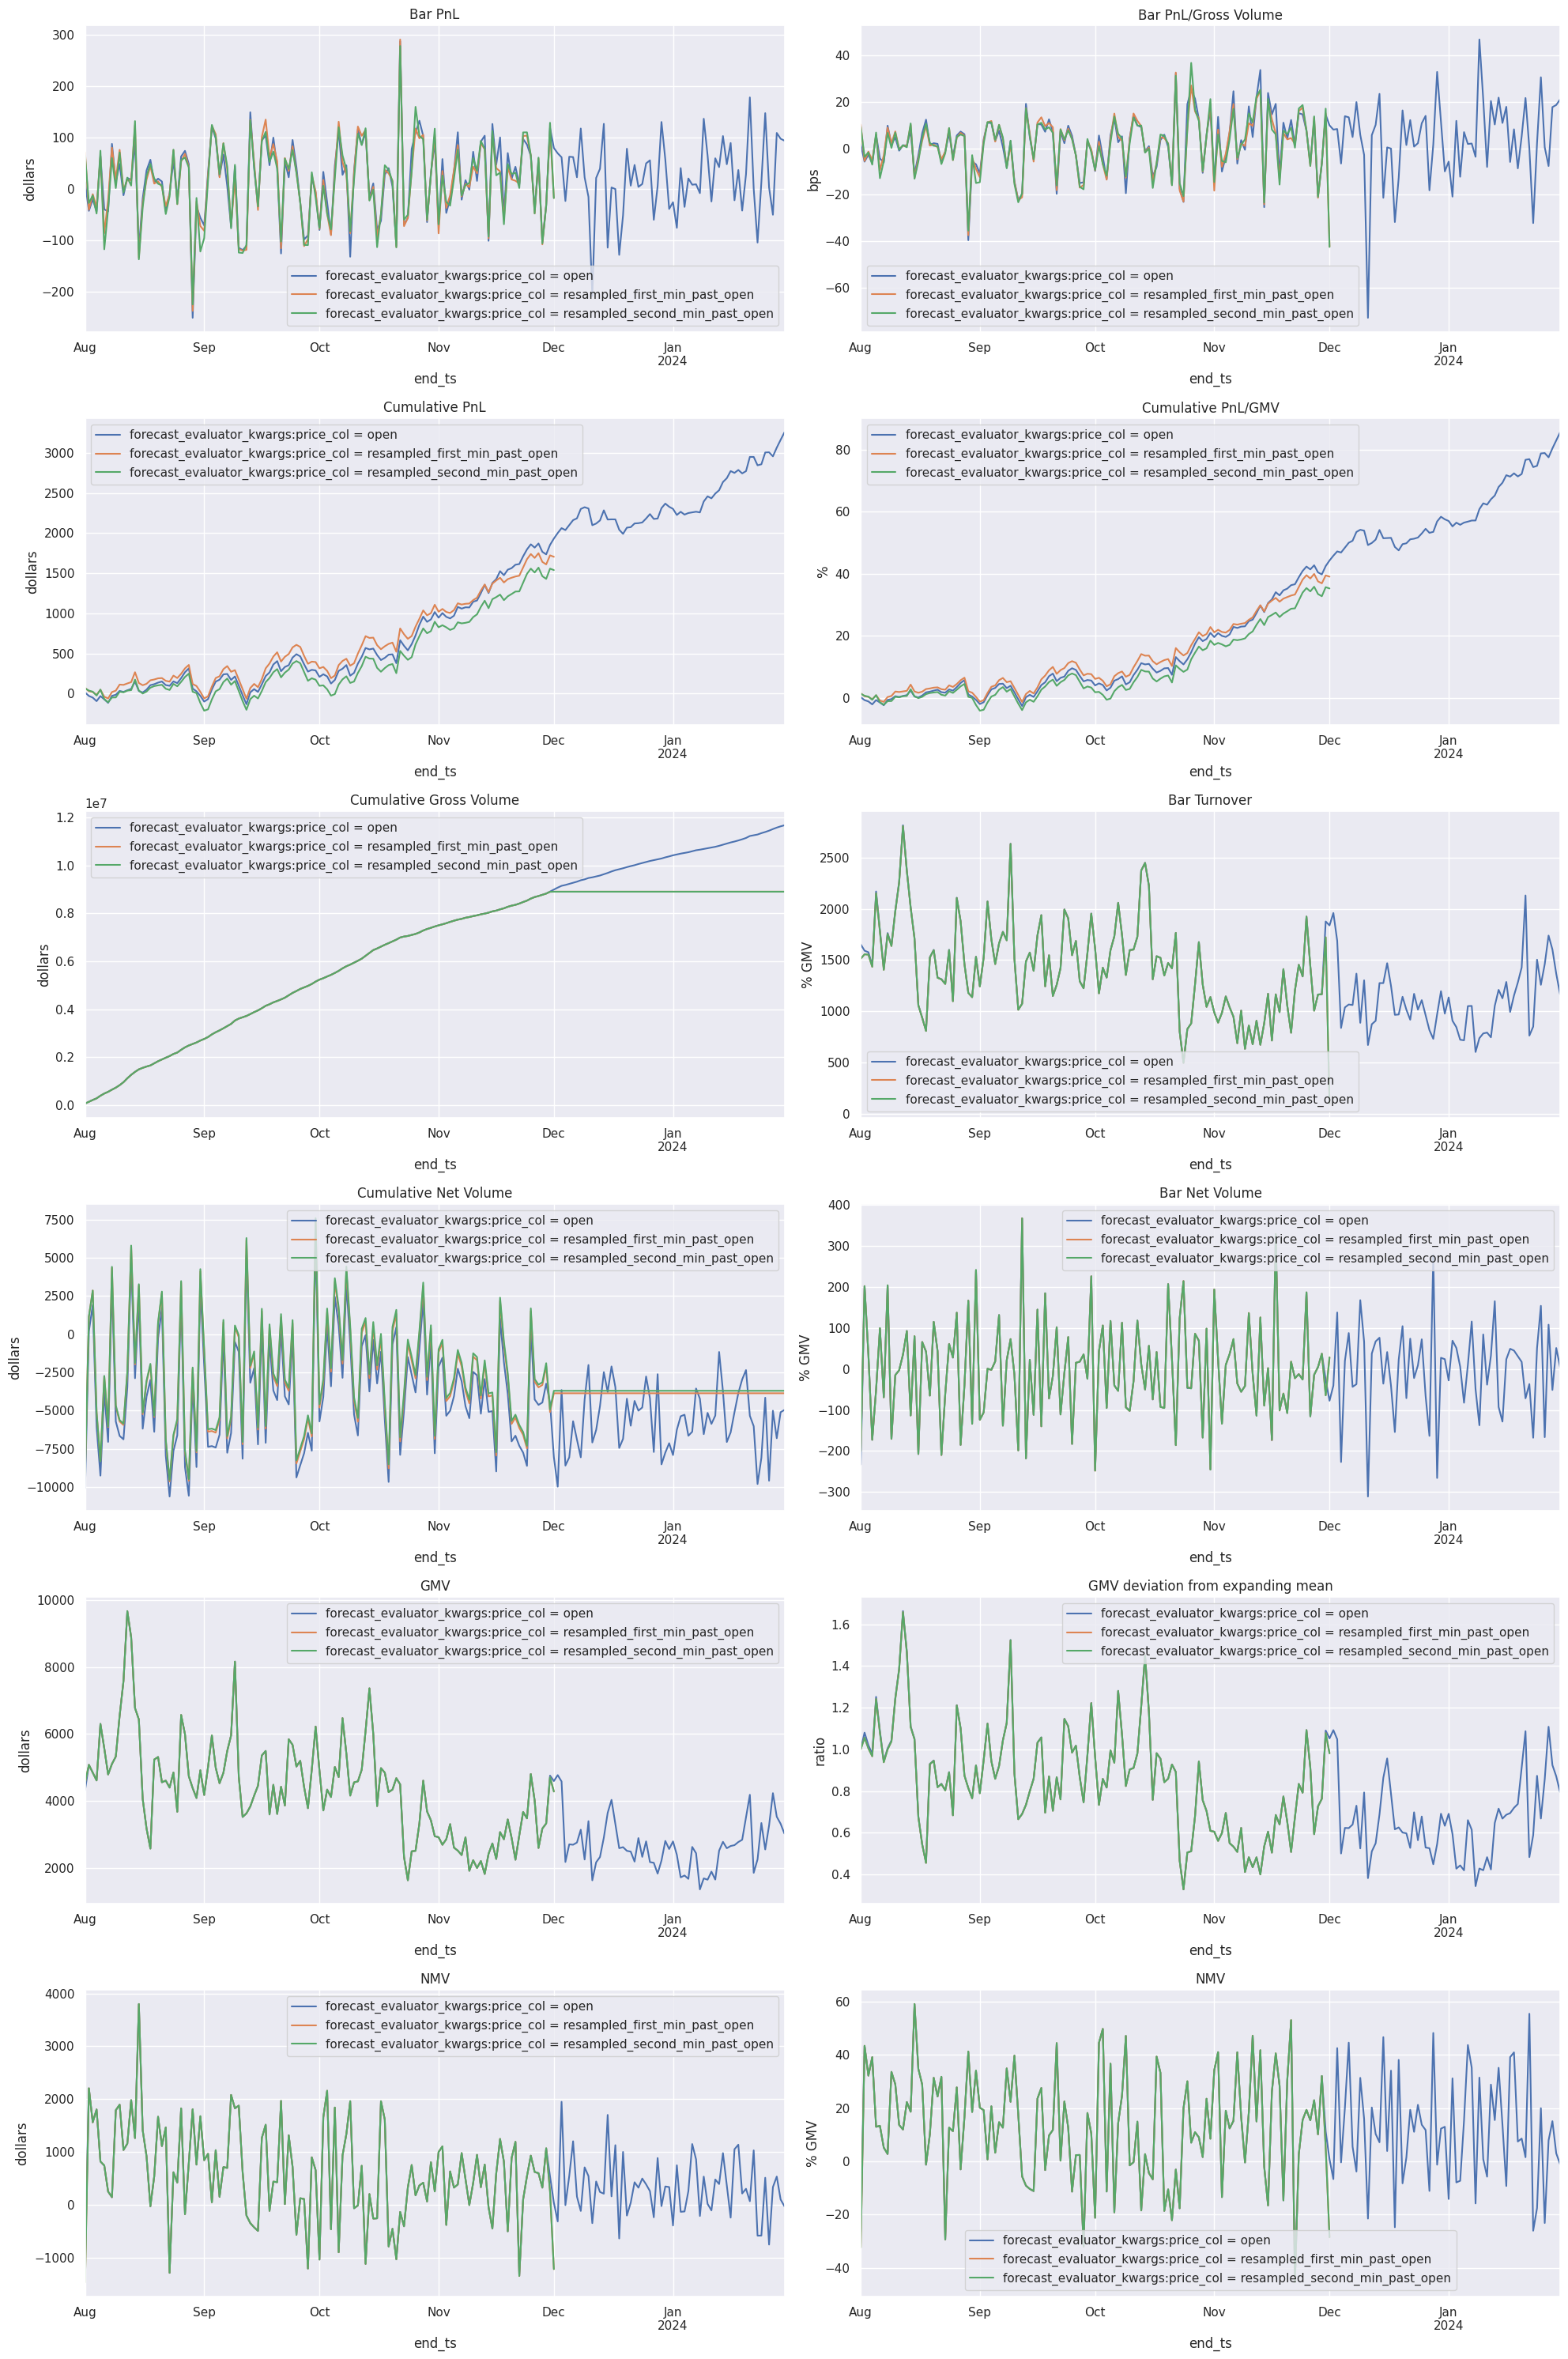

In [24]:
coplotti.plot_portfolio_stats(
    portfolio_stats_df, freq=default_config["pnl_resampling_frequency"]
)

forecast_evaluator_kwargs:price_col = open                                forecast_evaluator_kwargs:price_col = resampled_first_min_past_open                                forecast_evaluator_kwargs:price_col = resampled_second_min_past_open                               
                                                        pnl pnl_in_bps  sgn_corr      corr                                                                 pnl pnl_in_bps  sgn_corr      corr                                                                  pnl pnl_in_bps  sgn_corr      corr
prediction                                                                                                                                                                                                                                                                                       
(-inf, -0.842]                                     0.120426   0.531370  0.097822  0.064652                                           0.047737                    0.157441  0.089962  0.025397                                           0.037321                     0.050878  0.091292  0.020152
(-0.842, -0.253]                                   0.049303  -0.685472  0.046030  0.026458                                          -0.001839                   -1.467486  0.001120 -0.000692                                          -0.001057                    -1.217699  0.002341 -0.000498
(-0.253, 0.253]                                    0.044268  -0.016557  0.051774  0.023720                                          -0.000360                   -0.504235  0.011340 -0.000184                                          -0.000457                    -0.594662  0.012175 -0.000209
(0.253, 0.842]                                     0.051668   1.563425  0.058199  0.027741                                           0.013002                    1.450910  0.003526  0.007174                                           0.013618                     1.674199 -0.001398  0.007480
(0.842, inf]                                       0.026062   5.660854  0.049880  0.014757                                           0.088920                    5.081364  0.095978  0.048695                                           0.084299                     4.951100  0.077637  0.046231

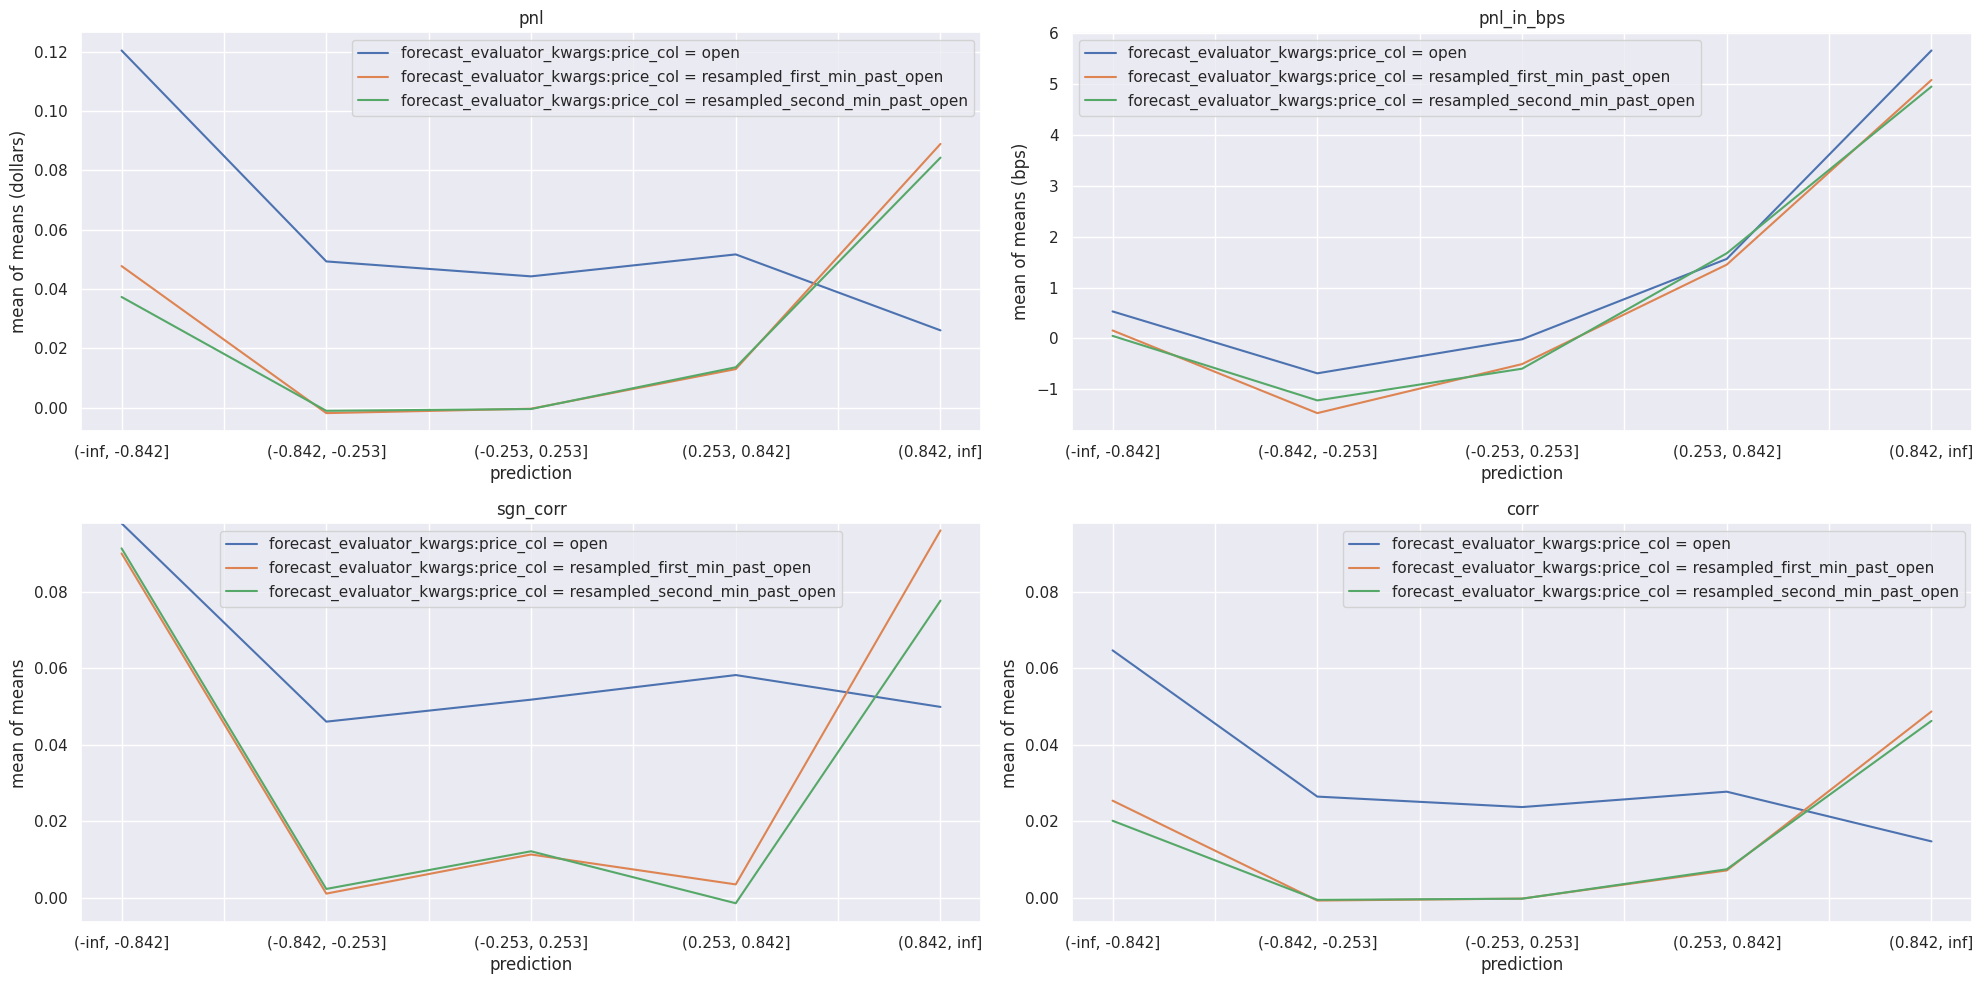

In [25]:
coplotti.plot_portfolio_binned_stats(
    portfolio_df_dict,
    **config["bin_annotated_portfolio_df_kwargs"],
)

# Compute aggregate portfolio stats

In [26]:
stats_computer = dtfmod.StatsComputer()

In [27]:
portfolio_stats, daily_metrics = stats_computer.compute_portfolio_stats(
    portfolio_stats_df,
    default_config["pnl_resampling_frequency"],
)
display(portfolio_stats)

forecast_evaluator_kwargs:price_col = open  forecast_evaluator_kwargs:price_col = resampled_first_min_past_open  forecast_evaluator_kwargs:price_col = resampled_second_min_past_open
ratios     sharpe_ratio                                                       4.57                                               2.84                                                                 2.54                   
           sharpe_ratio_standard_error                                        1.44                                               1.42                                                                 1.42                   
           sr.tval                                                            3.24                                               2.02                                                                 1.80                   
           sr.pval                                                            0.00                                               0.05                                                                 0.07                   
           kratio                                                             5.26                                               4.38                                                                 3.89                   
dollar     gmv_mean                                                        3808.76                                            4362.91                                                              4362.92                   
           gmv_stdev                                                       1495.07                                            1455.63                                                              1455.62                   
           annualized_mean_return                                          6502.88                                            3404.45                                                              3073.62                   
           annualized_volatility                                           1422.19                                            1200.15                                                              1209.40                   
           max_drawdown                                                     446.88                                             422.00                                                               462.17                   
           pnl_mean                                                          17.80                                              13.87                                                                12.52                   
           pnl_std                                                           74.42                                              76.28                                                                76.96                   
           turnover_mean                                                  63804.05                                           72409.96                                                             72410.79                   
           turnover_stdev                                                 25680.37                                           26029.83                                                             26029.72                   
           market_bias_mean                                                 510.74                                             588.32                                                               588.88                   
           market_bias_stdev                                                806.27                                             910.92                                                               910.97                   
percentage annualized_mean_return                                           170.73                                              78.03                                                                70.45                   
           annualized_volatility            